<a href="https://colab.research.google.com/github/bartiralira/public/blob/main/8_1_CoronaHack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Participantes (RM - NOME):***<br>
Vitor Luiz Carvalhal - 337129<br>
Ricardo Fabbro Antonelli - 339505<br>
Bartira Lira Lafiandre - 340177<br>
Tiago Batista Pessoa - 339575<br>


## 0. Bibliotecas e afins

In [ ]:
#Alocando memoria extra no colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

In [15]:
#Bibliotecas
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses
from keras.utils.vis_utils import plot_model

import numpy as np
import pandas as pd
import os
import glob
import shutil
import cv2


!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.44 s (started: 2021-07-19 23:11:20 +00:00)


In [3]:
# monta google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 20.7 s (started: 2021-07-19 23:06:54 +00:00)


## 1.Analisando os dados

In [ ]:
#ler arquivo com a avaliação das imagens
url = '/content/drive/MyDrive/Dataset/CoronaHack/Chest_xray_Corona_Metadata.csv'
nome_arquivos = pd.read_csv(url, engine='python', delimiter=",")
nome_arquivos.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


time: 1.38 s (started: 2021-07-18 16:21:30 +00:00)


In [ ]:
#verificando quantas imagens temos de cada classe inicial
nome_arquivos.Label.value_counts()

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64

time: 6.76 ms (started: 2021-07-17 00:11:15 +00:00)


In [ ]:
#verificando quantas imagens temos de cada dataset
nome_arquivos.Dataset_type.value_counts()

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

time: 6.48 ms (started: 2021-07-17 00:11:16 +00:00)


In [ ]:
#verificando quantas imagens temos de cada dataset
nome_arquivos.groupby(["Dataset_type","Label"], dropna=False)["X_ray_image_name"].count()

Dataset_type  Label   
TEST          Normal       234
              Pnemonia     390
TRAIN         Normal      1342
              Pnemonia    3944
Name: X_ray_image_name, dtype: int64

time: 9.17 ms (started: 2021-07-17 00:11:17 +00:00)


In [ ]:
# agrupando para ver quais seriam as demais categorias
nome_arquivos.groupby(["Dataset_type","Label","Label_2_Virus_category","Label_1_Virus_category"], dropna=False)["X_ray_image_name"].count()

Dataset_type  Label     Label_2_Virus_category  Label_1_Virus_category
TEST          Normal    NaN                     NaN                        234
              Pnemonia  NaN                     Virus                      148
                                                bacteria                   242
TRAIN         Normal    NaN                     NaN                       1342
              Pnemonia  ARDS                    Stress-Smoking               2
                        COVID-19                Virus                       58
                        SARS                    Virus                        4
                        Streptococcus           bacteria                     5
                        NaN                     Virus                     1345
                                                bacteria                  2530
Name: X_ray_image_name, dtype: int64

time: 12.9 ms (started: 2021-07-17 00:11:19 +00:00)


## 2. Vamos analisar e tratar as imagens
**Esse bloco demora 40min**

In [ ]:
# checando quantas imagens temos no diretorio de treino
path = '/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
images_train = [f for f in os.listdir(path)]
len(images_train)

In [ ]:
# checando quantas imagens temos no diretorio de teste
path = '/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
images_test = [f for f in os.listdir(path)]
len(images_test)

> * temos mais imagens do que avalições na planilha para o conjunto de treino. Vamos ter que coletar apenas as imagens que possui avaliação se é pneumonia ou não

* **Antes, vamos dar uma olhada no tamanho medio das imagens**


In [ ]:
#descobrindo o tamanho médio das imagens.(L x A)
# ESSE BLOCO DEMORA BASTANTE, LEVA EM MEDIA 1h. o TAMANHO MEDIO DAS IMAGENS EH: 970 X 1329
imgsize_real=[]
path="/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"
for f in os.listdir(path):
  imgsize_real.append((cv2.imread(path+f).shape[0],
                       cv2.imread(path+f).shape[1]))
  
a = np.array(imgsize_real)
np.average(a, axis=0)

In [ ]:
# vendo a distribuição dos tamanhos
plt.hist(a)

In [ ]:
print("menor L e A",min(imgsize_real))
print("maoir L e A",max(imgsize_real))

> Pegando uma imagem aleatoria para olhar a qualidade e ver como melhorar essa imagem após o redimensionamento

In [ ]:
cor_imagem=cv2.imread("/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person1944_bacteria_4869.jpeg")

In [ ]:
cor_imagem.shape

In [ ]:
cores = {"r": 0, "g": 1, "b": 2}
def histograma_bgr(imagem):
    for cor in cores:
        histograma = cv2.calcHist([imagem],[cores[cor]],None,[256],[0,256])
        plt.plot(histograma,color = cor)
        plt.xlim([0,256])
    plt.show()


histograma_bgr(cor_imagem)

> Essa imagem mostra que tem 3 canais de cores. Vamos transformar para escala de cinza

In [ ]:
imagem_gray = cv2.cvtColor(cor_imagem, cv2.COLOR_BGR2GRAY)
imagem_gray.shape

In [ ]:
plt.figure(figsize=(20,10))
plt.title("imagem tamanho original transformada para cinza")
plt.imshow(imagem_gray, cmap = "gray")

In [ ]:
imagem_gray2 = cv2.cvtColor(cv2.resize(cor_imagem,(200,200)),cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20,10))
plt.title("imagem em escala de cinza e redimencionada para 500 x 500")
plt.imshow(imagem_gray2, cmap = "gray")

In [ ]:
#imagem suavizada
imagem_suavizada = cv2.GaussianBlur(imagem_gray2, (5, 5), 0)

#plt.axis('off')
plt.figure(figsize=(20,10))
plt.imshow(imagem_suavizada, cmap='gray')
plt.title("Suavização Gaussiana")

> Não acho que a suavização tenha melhorado a qualidade da imagem

## 3. Movendo e transformando as imagems.
Preparando para mover as imagens.Essa etapa faz uma copia da imagem do diretorio original e separa em pastas. - **ESSA ETAPA DEMORA 40MIN**

* **Ok, agora vamos tratar as imagens em diretorios de acordo as suas classes. Faremos primeiro para as imagens de treino e depois para as de teste.**
* **Onde temos pneumonia, vamos segregar entre COVID e pneumonia em geral. Se for normal, atribuiremos "Normal"**

In [ ]:
# Criando lista de tuplas para treino e teste
listItensTreino=[]
listItensTest=[]
for i,j in nome_arquivos.iterrows():
  if (j["Dataset_type"] == "TRAIN" and j["Label"] == "Normal"):
      listItensTreino.append([j["X_ray_image_name"],j["Label"]])
  elif (j["Dataset_type"]== "TRAIN" and j["Label_2_Virus_category"]=="COVID-19"):
        listItensTreino.append([j["X_ray_image_name"],"COVID-19"])
  elif j["Dataset_type"]== "TRAIN":
        listItensTreino.append([j["X_ray_image_name"],"Pneumonia"])
  elif (j["Dataset_type"] == "TEST" and j["Label"] == "Normal"):
        listItensTest.append([j["X_ray_image_name"],j["Label"]])
  elif (j["Dataset_type"]== "TEST" and j["Label_2_Virus_category"]=="COVID-19"):
        listItensTest.append([j["X_ray_image_name"],"COVID-19"])
  elif j["Dataset_type"]== "TEST":
        listItensTest.append([j["X_ray_image_name"],"Pneumonia"])

print(len(listItensTreino))
print(len(listItensTest))

5286
624
time: 609 ms (started: 2021-07-16 15:31:24 +00:00)


In [ ]:
#vendo como ficou a sumarização para criar os diretorios
#treino
from collections import Counter
Counter(elem[1] for elem in listItensTreino)

Counter({'COVID-19': 58, 'Normal': 1342, 'Pneumonia': 3886})

time: 7.98 ms (started: 2021-07-16 15:31:27 +00:00)


In [ ]:
#criando os diretorios para treino
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/COVID-19")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/Normal")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/Pneumonia")


time: 18.3 ms (started: 2021-07-16 15:09:37 +00:00)


In [ ]:
#vendo como ficou a sumarização para criar os diretorios
#teste
from collections import Counter
Counter(elem[1] for elem in listItensTest)

Counter({'Normal': 234, 'Pneumonia': 390})

time: 9.2 ms (started: 2021-07-16 15:31:30 +00:00)


In [ ]:
#criando os diretorios para test
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/Normal")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/Pneumonia")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/COVID-19")

time: 16 ms (started: 2021-07-16 15:09:43 +00:00)


### 3.1 Copiando as imagens para seus diretorios e redimensionando para 500 pixels e transformando em escala de cinza.

---



In [ ]:
#TRAIN
#copiando as imagens para seus respectivos diretorios
# ESSA ETAPA SO DEVE SER FEITA UMA VEZ PARA ORGANIZAR AS IMAGENS
train_dir= "/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
train_dir_normal = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/Normal"
train_dir_COVID_19 = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/COVID-19"
train_dir_pneumonia = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/Pneumonia"

for i in listItensTreino:
  if i[1]=="Normal":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(train_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(train_dir_normal,i[0]), image_norm)
  elif i[1]=="COVID-19":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(train_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(train_dir_COVID_19,i[0]), image_norm)
  elif i[1]=="Pneumonia":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(train_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(train_dir_pneumonia,i[0]), image_norm)



time: 2min 57s (started: 2021-07-16 15:12:14 +00:00)


In [ ]:
#TEST
#copiando as imagens para seus respectivos diretorios
# ESSA ETAPA SO DEVE SER FEITA UMA VEZ PARA ORGANIZAR AS IMAGENS
test_dir= "/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"
test_dir_normal = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/Normal"
test_dir_pneumonia = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/Pneumonia"

for i in listItensTest:
  if i[1]=="Normal":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(test_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(test_dir_normal,i[0]), image_norm)
  elif i[1]=="Pneumonia":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(test_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(test_dir_pneumonia,i[0]), image_norm)


time: 3min 15s (started: 2021-07-16 15:15:20 +00:00)


## 4. criando os arquivos de treino e teste

In [4]:
#utilizaremos o orquestrador de imagem "DataGenerator"
#load das imagens com aumentation . Separando em treino e 20% validação
train_datagen = preprocessing.image.ImageDataGenerator(validation_split=0.20)

time: 1.81 ms (started: 2021-07-19 23:07:23 +00:00)


> Usaremos um batch_size de 500 pois temos muitas imagens e uma imagem de 500 x 500 pois, de acordo com o histograma apresentado anteriormente, esse é um valor seguro.

In [5]:
#Criando subset de treino
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train',
    batch_size=300,
    color_mode = 'grayscale',
    #class_mode="categorical",
    subset='training',
    target_size=(200, 200))

Found 4230 images belonging to 3 classes.
time: 28.4 s (started: 2021-07-19 23:07:25 +00:00)


In [6]:
#criando subset de validação
valid_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train',
    batch_size=300,
    color_mode = 'grayscale',
    #class_mode="categorical",
    subset='validation',
    target_size=(200, 200))

Found 1056 images belonging to 3 classes.
time: 110 ms (started: 2021-07-19 23:07:54 +00:00)


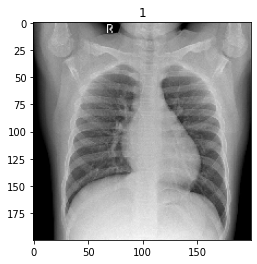

time: 2min 23s (started: 2021-07-19 23:07:55 +00:00)


In [7]:
#Visualizando 
x,y = train_generator.next()
for i in range(0,1):
    image = x[i]   
    plt.title(y[i].argmax(axis=-1))
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()
    



In [8]:
num_classes = len(train_generator.class_indices)
print(num_classes)

3
time: 1.21 ms (started: 2021-07-19 23:10:23 +00:00)


In [9]:
#pegando o tamanho da imagem para usar na modelagem
imgsize = x.shape
print(imgsize[1])
print(imgsize[2])
print(imgsize[3])

200
200
1
time: 1.61 ms (started: 2021-07-19 23:10:23 +00:00)


## 5. Modelando a rede

In [10]:
#Definindo quantidade de passos pela divisao da quantidade de imagens pelo tamanho do bach
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("Quantidade de passos para treino = ",STEP_SIZE_TRAIN)
print("Quantidade de passos para validacao = ",STEP_SIZE_VALID)

Quantidade de passos para treino =  14
Quantidade de passos para validacao =  3
time: 2.03 ms (started: 2021-07-19 23:10:25 +00:00)


In [11]:
model = Sequential()

model.add(Conv2D(32, (7, 7), input_shape=(imgsize[1],imgsize[2],imgsize[3]), activation='relu', padding="same")) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Remove 30% dos dados de entrada aleatoriamente 
model.add(Dropout(0.3))

model.add(Flatten())

print( model.output_shape)
model.add(Dense(512, activation='relu'))
print( model.output_shape)
model.add(Dense(128, activation='relu'))
print( model.output_shape)
model.add(Dense(64, activation='relu'))
print( model.output_shape)
model.add(Dense(num_classes, activation = 'softmax'))
print( model.output_shape)

(None, 9600)
(None, 512)
(None, 128)
(None, 64)
(None, 3)
time: 360 ms (started: 2021-07-19 23:10:27 +00:00)


In [12]:
# compilando o modelo
#model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(), metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 8.4 ms (started: 2021-07-19 23:10:35 +00:00)


In [13]:
# adicionando o model checkpoint para guardar o melhor resultado do modelo
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack-v2.hdf5', monitor='val_accuracy', mode= 'auto', save_best_only=True, verbose =1)
# save_weights_only=True,

time: 1.25 ms (started: 2021-07-19 23:10:47 +00:00)


In [17]:
#vendo o resultado do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 96)        1

> **O TREINO DO MODELO COM 50 EPOCAS LEVOU 2HS**

In [18]:
# treinando o modelo
hist=model.fit_generator(train_generator, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40, 
                    callbacks=[mcp_save])



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
14/14 [==============================] - 2222s 159s/step - loss: 1.7738 - accuracy: 0.6435 - val_loss: 0.3548 - val_accuracy: 0.7422

Epoch 00001: val_accuracy improved from -inf to 0.74222, saving model to /content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack-v2.hdf5
Epoch 2/40
14/14 [==============================] - 171s 12s/step - loss: 0.2822 - accuracy: 0.8226 - val_loss: 0.2473 - val_accuracy: 0.8444

Epoch 00002: val_accuracy improved from 0.74222 to 0.84444, saving model to /content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack-v2.hdf5
Epoch 3/40
14/14 [==============================] - 168s 12s/step - loss: 0.1590 - accuracy: 0.9140 - val_loss: 0.1561 - val_accuracy: 0.9000

Epoch 00003: val_accuracy improved from 0.84444 to 0.90000, saving model to /content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack-v2.hdf5
Epoch 4/40
14/14 [==============================] - 169s 12s/step - loss: 0.1344 - accuracy: 0.9214 - val_loss: 0.1252 - val_acc

## 6. Avaliando o modelo e Testando conjunto de teste

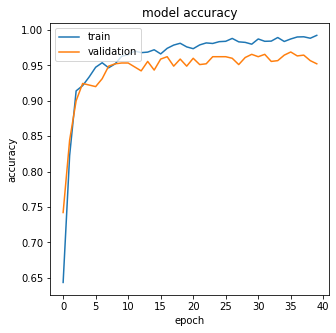

time: 284 ms (started: 2021-07-20 01:48:08 +00:00)


In [19]:
plt.figure(figsize=(5,5)) 
plt.figure(1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

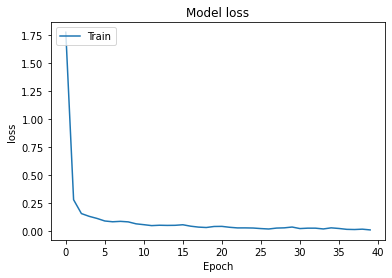

time: 158 ms (started: 2021-07-20 01:48:12 +00:00)


In [20]:
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Avaliação no conjunto de treinamento e validação:**<br>
Tentativa com 10 epocas = Acuracia de validação de 90% com loss de 0.24. <br>
Tentativa com 50 epocas = Acuracia de validação de 95% com loss de 0.24.<br>
Tentativa com 25 epocas = Acuracia de validação de 95% com loss de 0.29.<br>
Tentativa com 40 epocas = Acuracia de validação de 96% com loss de 0.07.<br>
* Adicionado padding = "same" para cada camada<br>
* Adicionado mais uma camada de convolução + pooling e padding = "valid"<br>

O padding pode ter ajudado nessa arquitetura vendo que ele adiciona mais informação a rede ao considerar mais as bordas.

In [21]:
#gerando dados de teste
test_datagen = preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test',
    batch_size=1,
    color_mode = 'grayscale',
    #class_mode="categorical",
    shuffle = False,
    target_size=(200, 200))

Found 624 images belonging to 3 classes.
time: 3.4 s (started: 2021-07-20 01:48:18 +00:00)


In [22]:
#avaliação do modelo
scores = model.evaluate_generator(test_generator)   

print("%s%.2f  "% ("Loss     : ", scores[0]))
print("%s%.2f%s"% ("Accuracy : ", scores[1]*100, "%"))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss     : 0.89  
Accuracy : 77.88%
time: 4min 47s (started: 2021-07-20 01:48:36 +00:00)


**Avaliação no conjunto de teste:**<br>
10 Epocas > Acuracia: 74,52% e loss:0.73<br>
50 Epocas > Acuracia: 74,20% e loss:2.01<br>
25 Epocas > Acuracia: 71,96% e loss:2.77<br>
40 Epocas > Acuracia: 77,8% e loss: 0.89<br>
* Adicionado padding = "same" para cada camada<br>
* Adicionado mais uma camada de convolução + pooling e padding = "valid"<br>

> realiza a predicao no conjunto de teste e usando argmax para selecionar a melhor predição

In [23]:
#realiza a predição no conjunto de teste
predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = predictions.argmax(axis=-1)
y_true=test_generator.classes

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


624/624 [==============================] - 14s 21ms/step
time: 13.7 s (started: 2021-07-20 01:56:30 +00:00)


In [31]:
#classes encontradas no conjunto de teste
test_generator.class_indices

{'COVID-19': 0, 'Normal': 1, 'Pneumonia': 2}

time: 3.03 ms (started: 2021-07-20 01:57:36 +00:00)


In [32]:
#jogando os labels do conjunto de teste numa lista
labels = []
for l, v in test_generator.class_indices.items():
    labels.append((v,l))
labels   

[(0, 'COVID-19'), (1, 'Normal'), (2, 'Pneumonia')]

time: 5.78 ms (started: 2021-07-20 01:57:37 +00:00)


In [33]:
#jogando as predicoes numa lista usando o argmax para selecionar a melhor predicao de cada vetor
y_pred_list = []
for p in range(predictions.shape[0]):
    y_pred_list.append(predictions[p].argmax(axis=-1))

time: 4.76 ms (started: 2021-07-20 01:57:38 +00:00)


In [34]:
def join(l1, l2):
  return [list(x) for x in zip(l1, l2)]

print(join(y_true, y_pred))

[[1, 1], [1, 2], [1, 1], [1, 0], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 0], [1, 1], [1, 2], [1, 1], [1, 0], [1, 2], [1, 0], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 0], [1, 1], [1, 1], [1, 0], [1, 0], [1, 2], [1, 1], [1, 1], [1, 0], [1, 2], [1, 0], [1, 0], [1, 0], [1, 0], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 1], [1, 2], [1, 1], [1, 2], [1, 1], [1, 2], [1, 1], [1, 2], [1, 2], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 2], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 1], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2],

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_true, y_pred))
pred_class= model.predict_classes(test_generator)
print('Accuracy Score:\n', accuracy_score(y_true, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.98      0.42      0.59       234
           2       0.76      0.99      0.86       390

    accuracy                           0.78       624
   macro avg       0.58      0.47      0.48       624
weighted avg       0.84      0.78      0.76       624

Accuracy Score:
 0.7788461538461539
time: 14.5 s (started: 2021-07-20 01:56:59 +00:00)


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


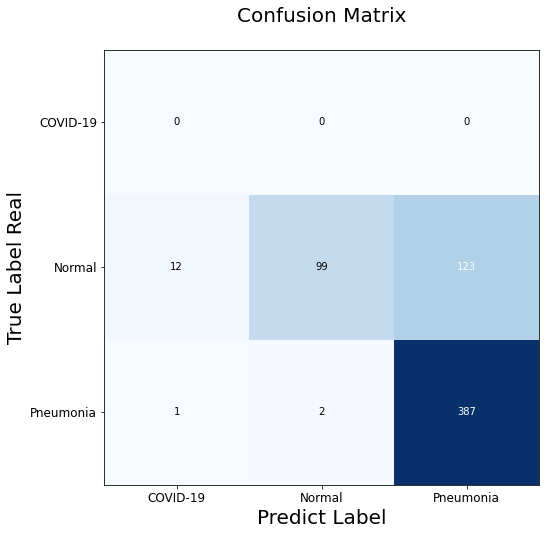

time: 317 ms (started: 2021-07-20 01:57:14 +00:00)


In [29]:
from mlxtend.plotting import plot_confusion_matrix
#confusion_matrix(y_true, y_pred)
#plot_confusion_matrix(model, y_true, y_pred, normalize='true')
classes=test_generator.class_indices

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel('True Label Real',fontsize=20)
plt.xlabel('Predict Label',fontsize=20)
plt.show()

> **Observação** Para a classe de COVID não temos imagem no conjunto de teste, por tanto essa classificação não temos como aferir a acuracia uma vez que so temos rx com COVID no conjunto de treino.

1  igual 1


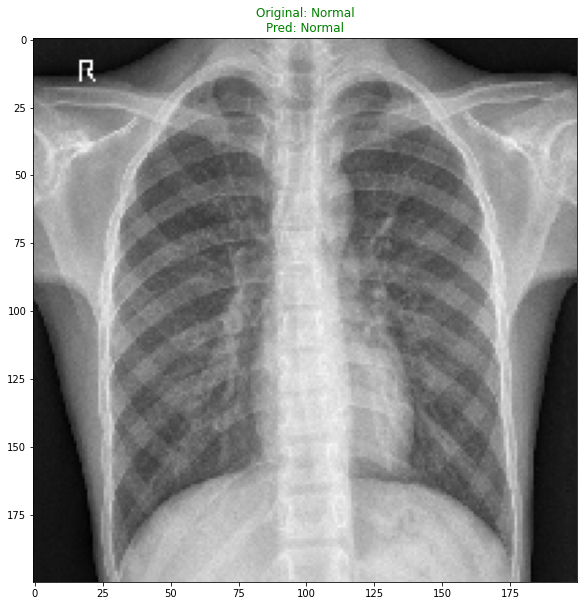

time: 355 ms (started: 2021-07-20 01:58:53 +00:00)


In [36]:
#genrado a avaliação na imagem usando o generator.next()
x,y = test_generator.next()
y_pred_test = model.predict(x)

y_original = y[0].argmax(axis=-1)
y_predicao = np.argmax(y_pred_test)

print(y_original," igual", y_predicao)

for i,v in enumerate(labels):
  if v[0] == y_original:
    y_original_label =v[1]

for i,v in enumerate(labels):
  if v[0] == y_predicao:
    y_predicao_label =v[1]
    
plt.figure(figsize=(10,10))    
title_text=("%s%s%s%s%s"%("Original: ", y_original_label, "\n", "Pred: ", y_predicao_label))

if y_original==y_predicao:
  plt.title(title_text,color='green')
else:
  plt.title(title_text, color='red')

image=x[0]
plt.imshow(image[:,:,0],cmap='gray')
plt.show()

## 7. Testando uma imagem real

In [37]:
# loading models
model_path="/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack.hdf5"
model = load_model(model_path)

time: 17.3 s (started: 2021-07-20 01:59:04 +00:00)


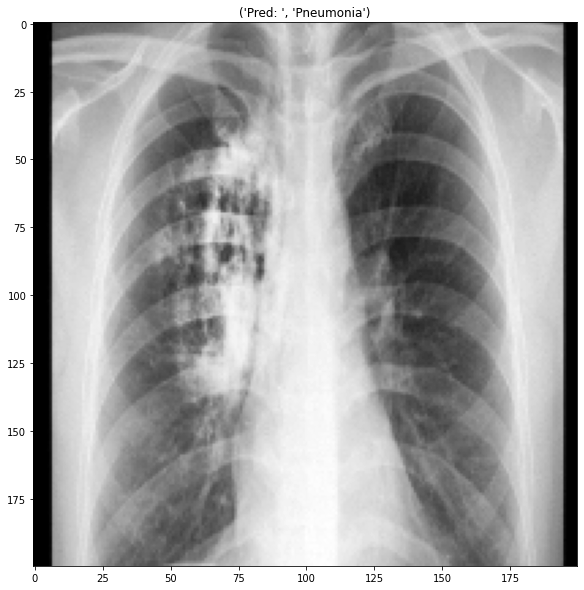

time: 433 ms (started: 2021-07-20 02:10:10 +00:00)


In [50]:
#Buscando uma imagem real
#Essa imagem eh uma imagem de covid mas nao esta no dataset do professor. Ela foi coletada da internet. Como não temos nenhuma imagem no conjunto de teste o modelo nao consegue acertar essa predição e considera a imagem como pneumonia apenas.
img_real="/content/drive/MyDrive/Dataset/CoronaHack/teste_real/covid.jpg"
image_norm= cv2.cvtColor(cv2.resize(cv2.imread(img_real),(200,200)), cv2.COLOR_BGR2GRAY)

#adicionando dimensões para entrada no modelo
img2= image_norm.reshape(1,200, 200,1)

#Realizando a classificação da imagem
y_pred_real = model.predict(img2)

#genrado a visualização na imagem
y_predicao = np.argmax(y_pred_real)

for i,v in enumerate(labels):
  if v[0] == y_predicao:
    y_predicao_label =v[1]
    
plt.figure(figsize=(10,10))    
title_text=("Pred: ", y_predicao_label)
plt.title(title_text)
image_new=img2[0]
plt.imshow(image_new[:,:,0],cmap='gray')
plt.show()